<div style='background-color: #e6f7ff; border: 3px solid #0078FF; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#0078FF"><b>🗂️ 1. Custom Datasets & DataLoaders 🗂️</b></font>
</div>

In [1]:
!pip install timm torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaipaulchinthakuntla","key":"12baf4e1d0afa959c3b2690d16350d1d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images
!unzip ai-generated-images-vs-real-images.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0
 93% 441M/476M [00:00<00:00, 367MB/s]
100% 476M/476M [00:01<00:00, 440MB/s]
Archive:  ai-generated-images-vs-real-images.zip
  inflating: dataset/AiArtData/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg  
  inflating: dataset/AiArtData/AiArtData/-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg  
  inflating: dataset/AiArtData/AiArtData/-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg  
  inflating: dataset/AiArtData/AiArtData/-yellow-kimono-with-a-golden-crown-and-a-very-detailed-Barn-owl-copy-800x800.jpg  
  inflating: dataset/AiArtData/AiArtData/.amazonaws.com2Fpublic2Fimages2Ff89de3bb-279b-42c9-9822-a653fb5b21e6_600x480.png  
  inflating: dataset/AiArtData/AiArtData/0002_AI-in-animal-classification.png  
  inflating: da

In [4]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/content/dataset"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

28
2
50
{'AiArtData': 0, 'RealArt': 1}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


<div style='background-color: #e6f7ff; border: 3px solid #007acc; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#007acc"><b>📊 2. Data Visualization 📊</b></font>
</div>

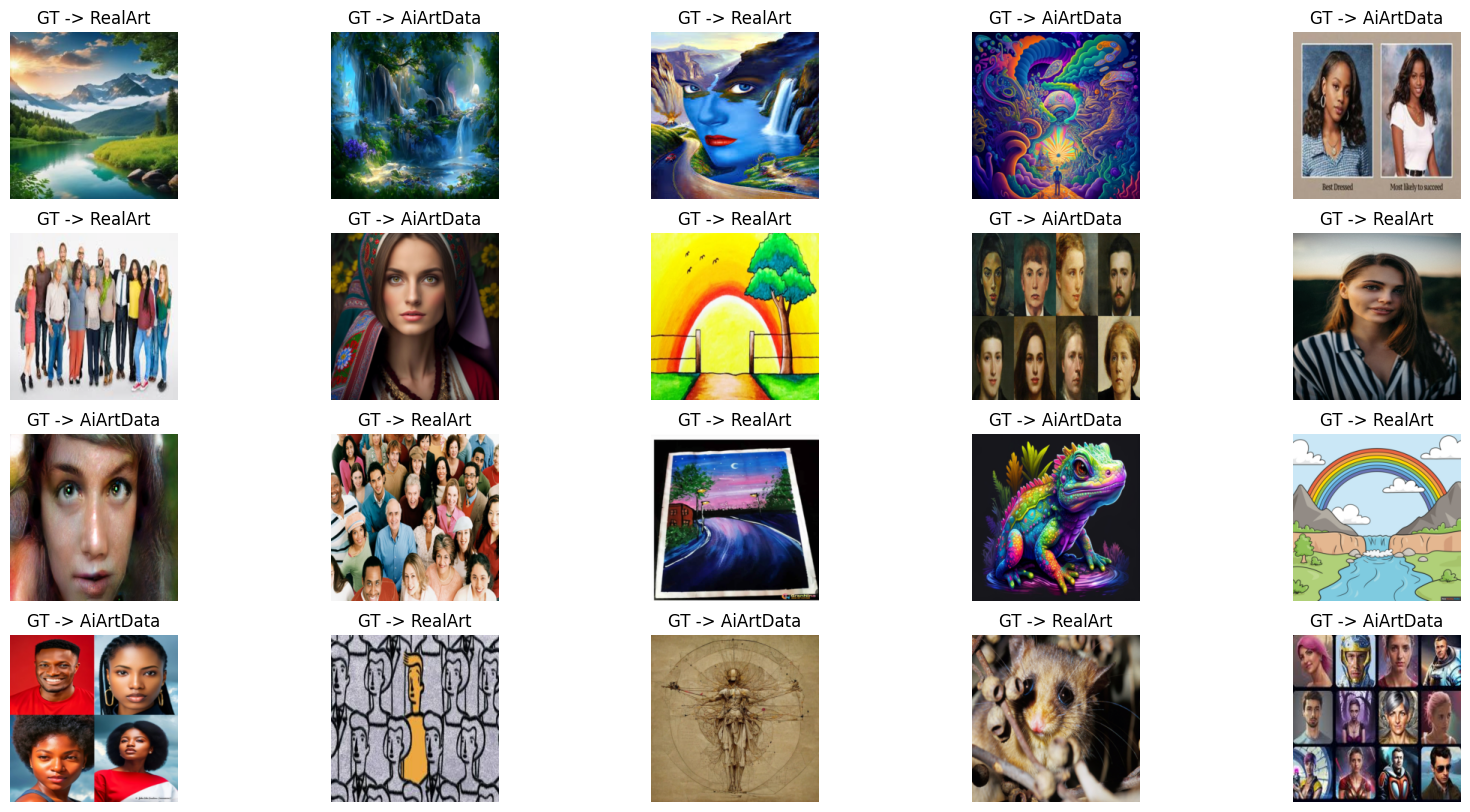

In [5]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

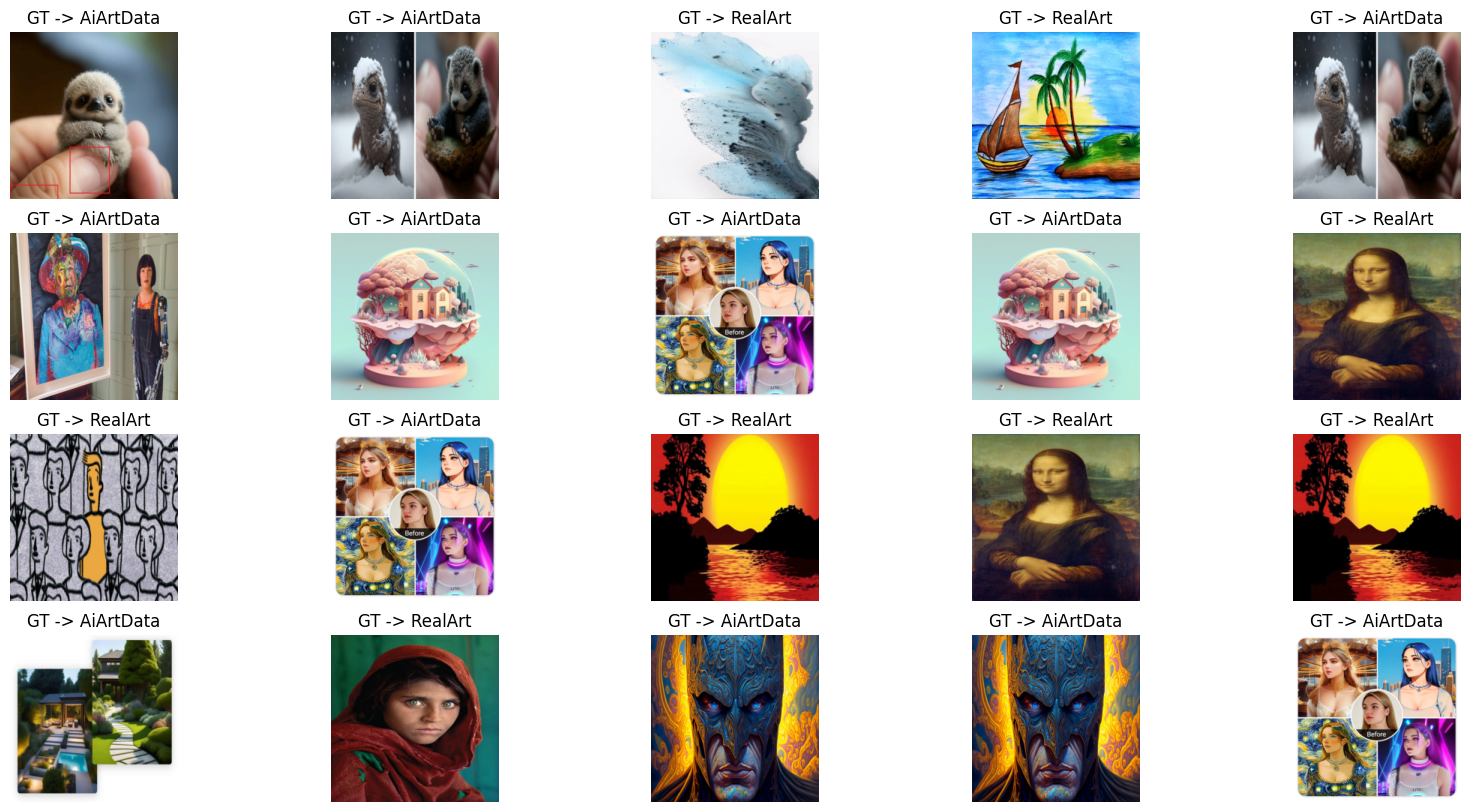

In [6]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

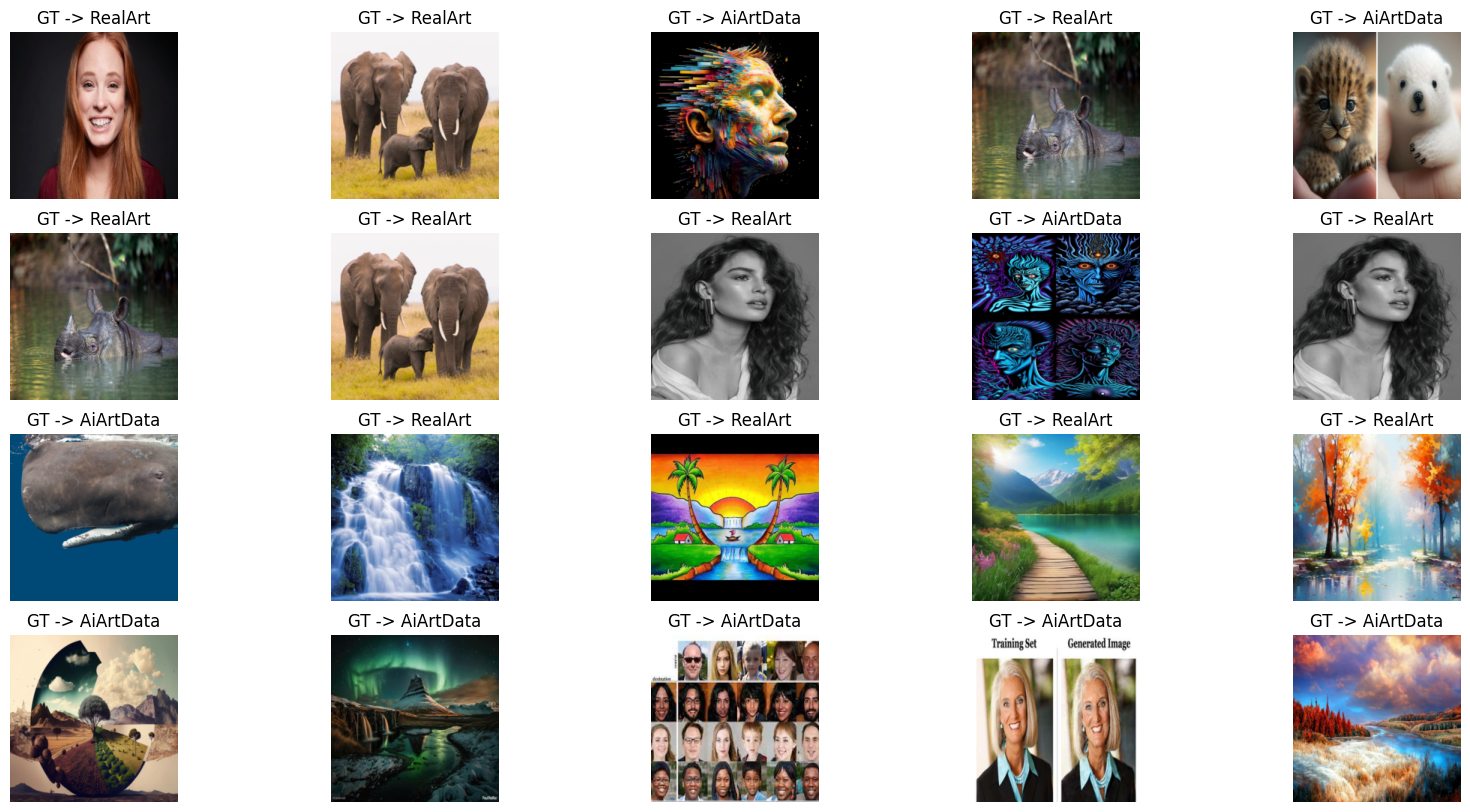

In [7]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<div style='background-color: #ffe6f2; border: 3px solid #ff1493; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#ff1493"><b>📈 3. Data Analysis 📈</b></font>
</div>

/tmp/ipython-input-8-1844673426.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60)


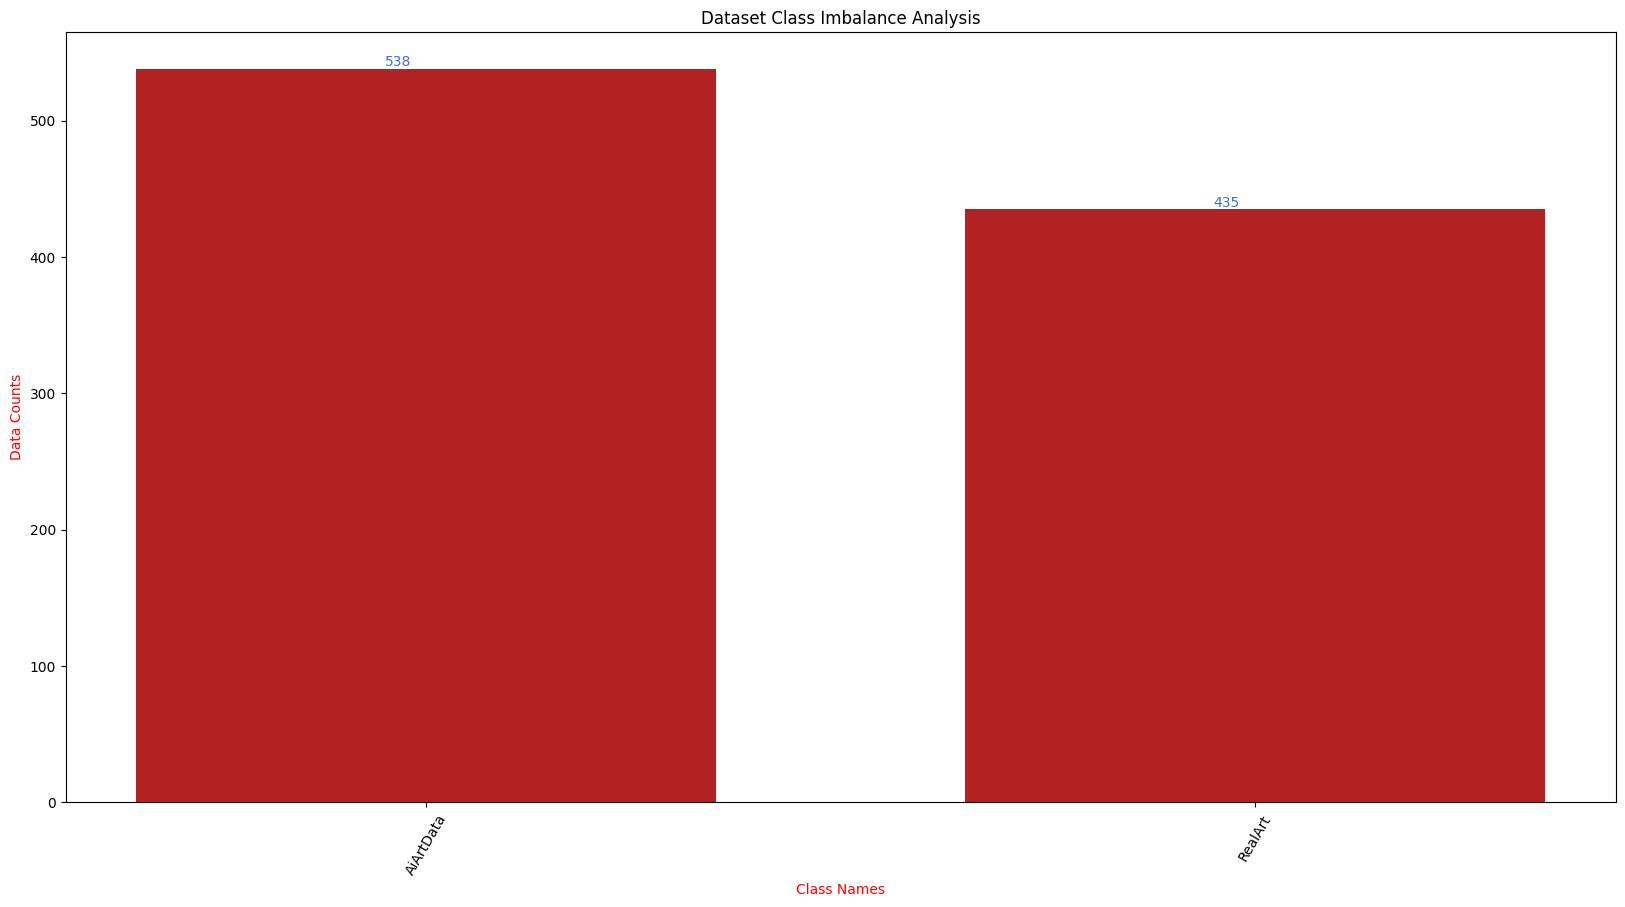

In [8]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

<div style='background-color: #f0f9e8; border: 3px solid #4CAF50; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#4CAF50"><b>✨ 4. AI Model Train and Validation ✨</b></font>
</div>

In [15]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "AI", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
1it [00:04,  4.40s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.02it/s]

1-epoch train process is completed!
1-epoch train loss          -> 1.340
1-epoch train accuracy      -> 0.629
1-epoch train f1-score      -> 0.631



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1-epoch validation process is completed!
1-epoch validation loss     -> 0.523
1-epoch validation accuracy -> 0.708
1-epoch validation f1-score -> 0.734


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.02it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.479
2-epoch train accuracy      -> 0.749
2-epoch train f1-score      -> 0.750



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2-epoch validation process is completed!
2-epoch validation loss     -> 0.675
2-epoch validation accuracy -> 0.688
2-epoch validation f1-score -> 0.656
Loss value did not decrease for 1 epochs


5it [00:06,  1.18it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:28,  1.01s/it]

3-epoch train process is completed!
3-epoch train loss          -> 0.293
3-epoch train accuracy      -> 0.879
3-epoch train f1-score      -> 0.882



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3-epoch validation process is completed!
3-epoch validation loss     -> 0.891
3-epoch validation accuracy -> 0.771
3-epoch validation f1-score -> 0.734
Loss value did not decrease for 2 epochs


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
5it [00:05,  1.01it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
21it [00:21,  1.26it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.02it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.195
4-epoch train accuracy      -> 0.919
4-epoch train f1-score      -> 0.916



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


4-epoch validation process is completed!
4-epoch validation loss     -> 0.488
4-epoch validation accuracy -> 0.812
4-epoch validation f1-score -> 0.797


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
22it [00:23,  1.46it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.01it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.129
5-epoch train accuracy      -> 0.950
5-epoch train f1-score      -> 0.949



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5-epoch validation process is completed!
5-epoch validation loss     -> 0.549
5-epoch validation accuracy -> 0.833
5-epoch validation f1-score -> 0.812
Loss value did not decrease for 3 epochs


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
10it [00:12,  1.61it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.03it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.090
6-epoch train accuracy      -> 0.973
6-epoch train f1-score      -> 0.973



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


6-epoch validation process is completed!
6-epoch validation loss     -> 1.051
6-epoch validation accuracy -> 0.750
6-epoch validation f1-score -> 0.719
Loss value did not decrease for 4 epochs


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
6it [00:07,  1.41it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
28it [00:27,  1.00it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.040
7-epoch train accuracy      -> 0.987
7-epoch train f1-score      -> 0.986



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


7-epoch validation process is completed!
7-epoch validation loss     -> 1.170
7-epoch validation accuracy -> 0.792
7-epoch validation f1-score -> 0.734
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


<div style='background-color: #fff0f5; border: 3px solid #FF69B4; border-radius: 10px; padding: 8px; text-align: center;'>
    <font size="+2" color="#FF1493"><b>😍 5. Learning Curves 😍</b></font>
</div>

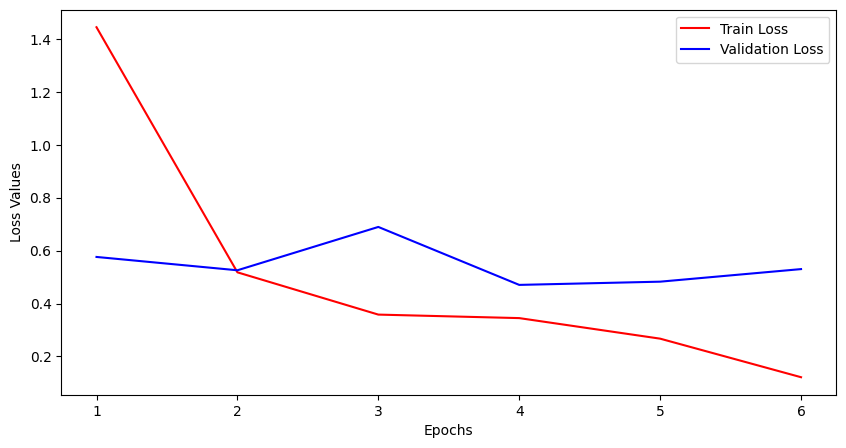

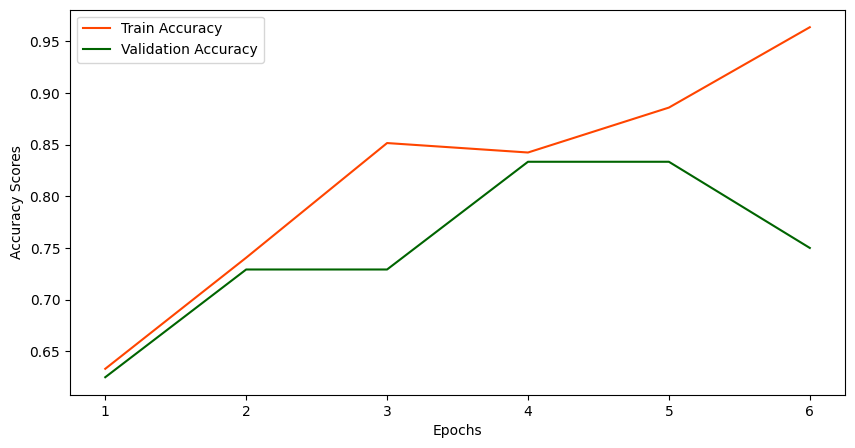

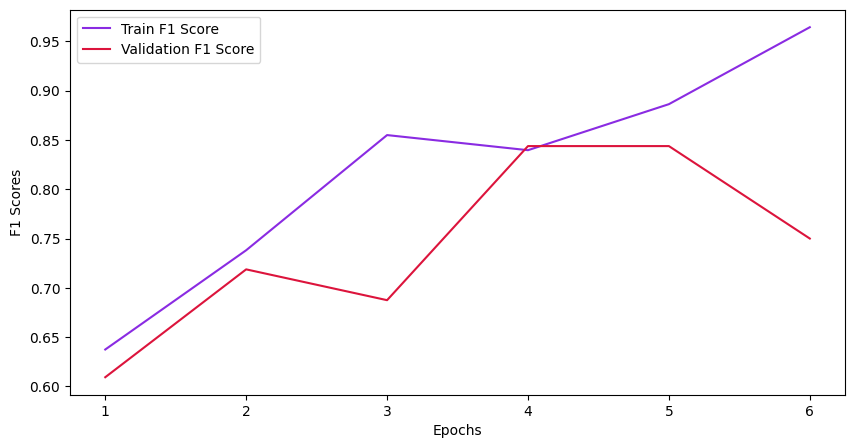

In [13]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()

    def visualize(self):

        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
    <font size="+1.8" color="#FF4500"><b>✅ 6. Inference and AI Model Performance Analysis with GradCAM ✅</b></font>
</div>

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
50it [00:02, 18.29it/s]


Accuracy of the model on the test data -> 0.600


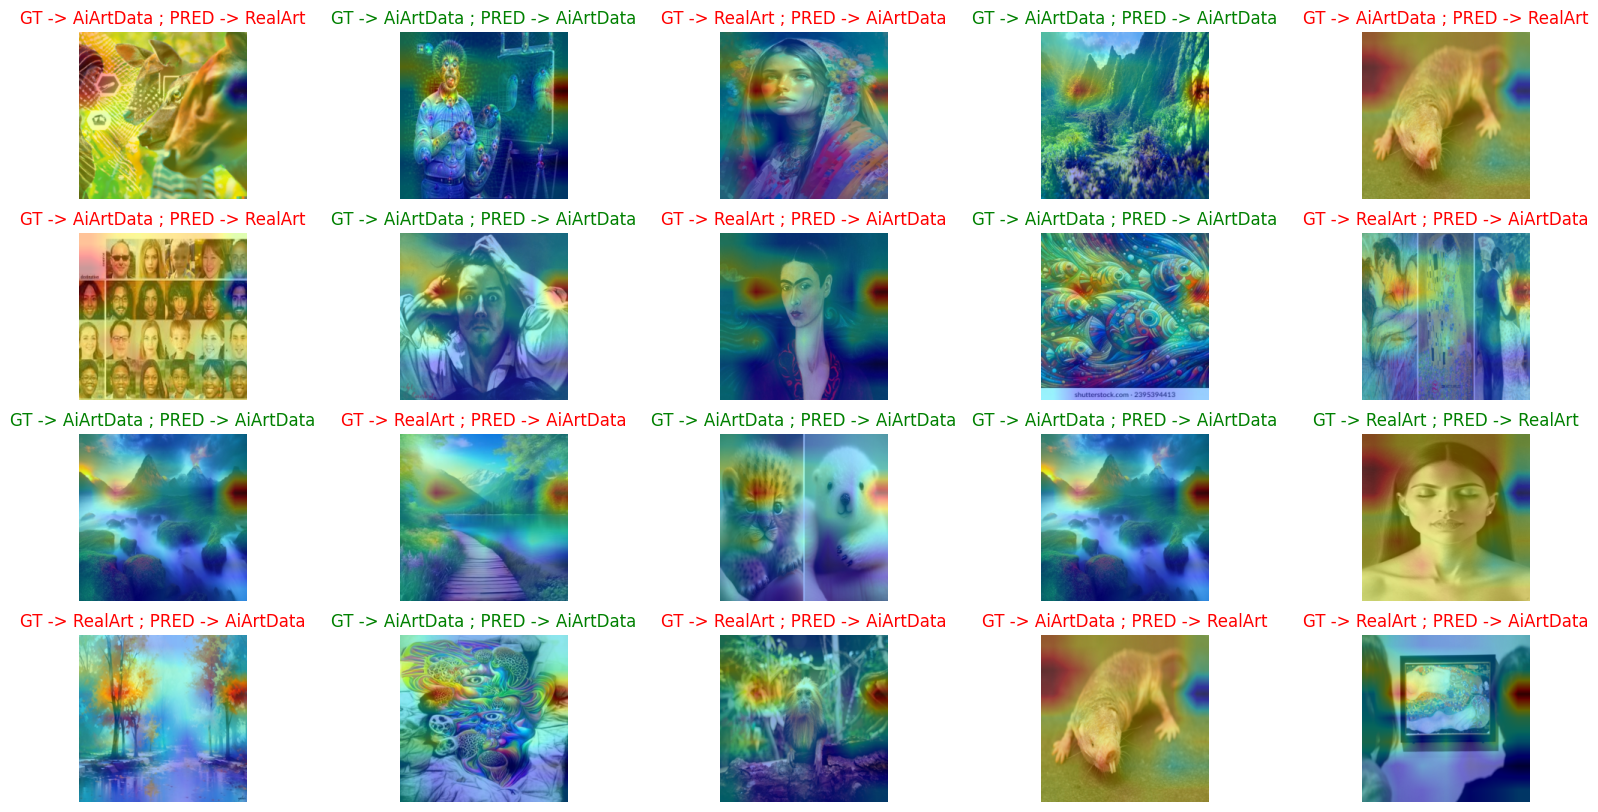

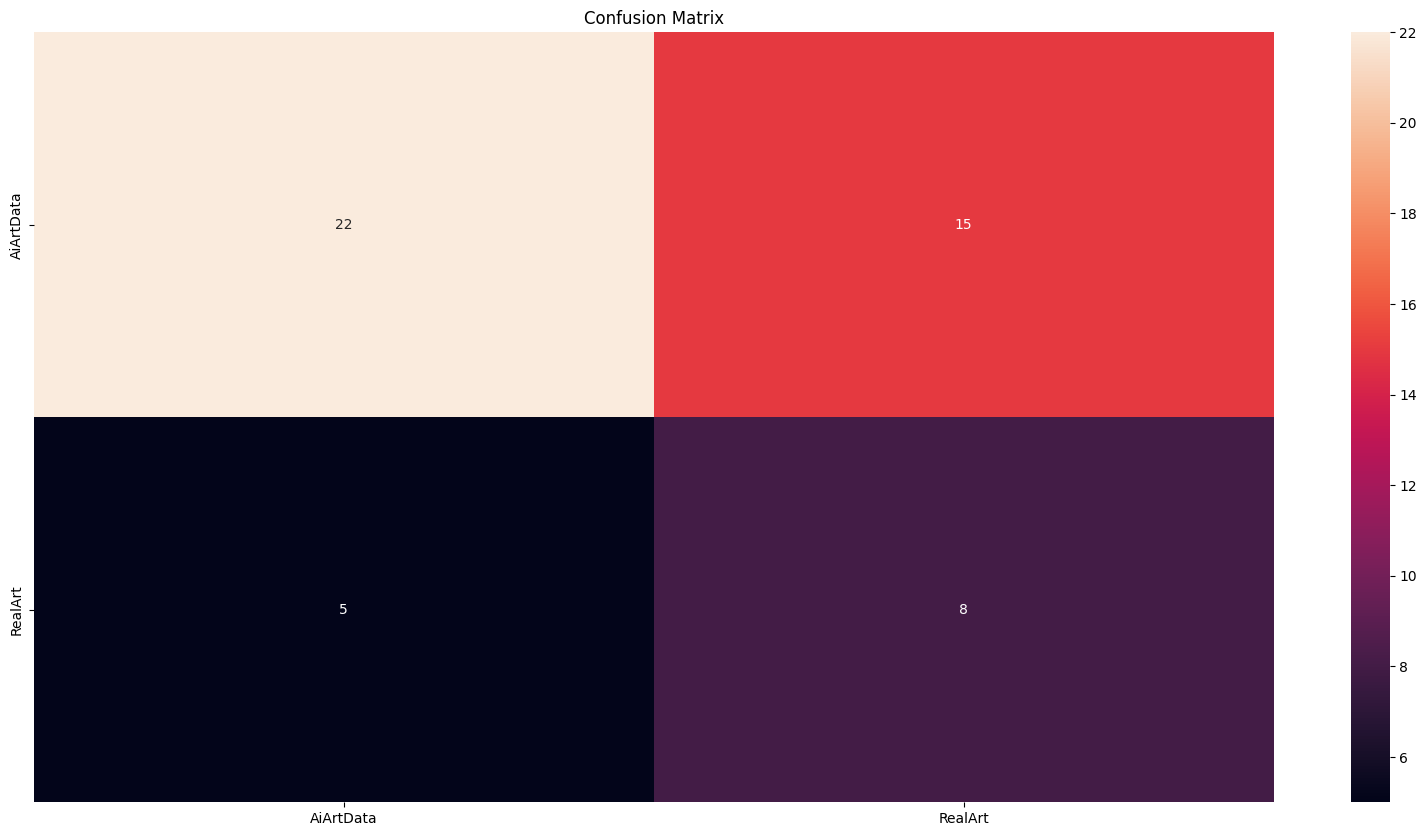

In [14]:
import cv2, seaborn as sns
from sklearn.metrics import confusion_matrix

class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

    plt.figure(figsize = (20, 10))
    sns.heatmap(confusion_matrix(preds, lbls), annot=True, fmt='d', xticklabels=cls_names, yticklabels=cls_names)
    plt.title("Confusion Matrix")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)